In [1]:
import cv2
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
# paths
left_img_path = '/media/shubham/GoldMine/datasets/KITTI/object/training/image_2/000035.png'
right_img_path = '/media/shubham/GoldMine/datasets/KITTI/object/training/image_3/000035.png'

left_img = cv2.cvtColor(cv2.imread(left_img_path), cv2.COLOR_BGR2RGB)
right_img = cv2.cvtColor(cv2.imread(right_img_path), cv2.COLOR_BGR2RGB)

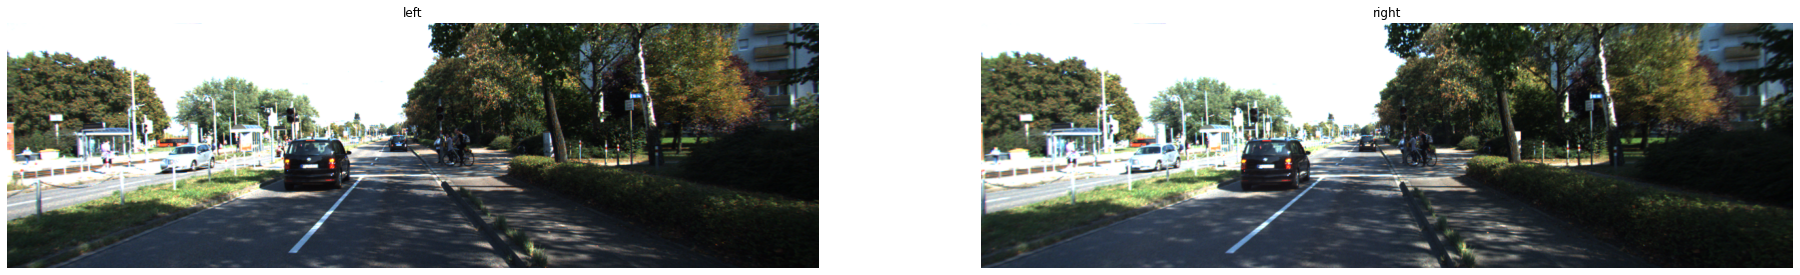

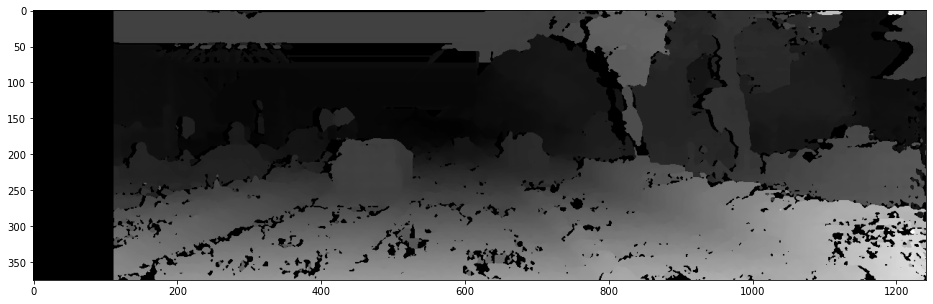

In [3]:
left_img_gray = cv2.cvtColor(left_img, cv2.COLOR_RGB2GRAY)
right_img_gray = cv2.cvtColor(right_img, cv2.COLOR_RGB2GRAY)

# disparity settings
blockSize = 7
min_disp = 0
num_disp = 112-min_disp
stereo = cv2.StereoSGBM_create(
    minDisparity = min_disp,
    numDisparities = num_disp,
    blockSize = blockSize,
    uniquenessRatio = 5,
    speckleWindowSize = 100,
    speckleRange = 32,
    disp12MaxDiff = 1,
    P1 = 8*3*blockSize**2,
    P2 = 32*3*blockSize**2
)
disparity = stereo.compute(left_img_gray,right_img_gray)


plt.figure(figsize=(32, 8))
plt.subplot(121)
plt.imshow(left_img)
plt.title('left')
plt.axis('off')
plt.subplot(122)
plt.imshow(right_img)
plt.title('right')
plt.axis('off')
plt.show()

plt.figure(figsize=(16, 8))
plt.imshow(disparity,'gray')
plt.show()

In [4]:
def apply_disparity(img, disp):
    batch_size, _, height, width = img.shape

    # Original coordinates of pixels
    x_base = torch.linspace(0, 1, width).repeat(batch_size,
                height, 1).type_as(img)
    y_base = torch.linspace(0, 1, height).repeat(batch_size,
                width, 1).transpose(1, 2).type_as(img)

    # Apply shift in X direction
    x_shifts = disp[:, 0, :, :]  # Disparity is passed in NCHW format with 1 channel
    flow_field = torch.stack((x_base + x_shifts, y_base), dim=3)
    # In grid_sample coordinates are assumed to be between -1 and 1
    output = F.grid_sample(img, 2*flow_field - 1, mode='bilinear',
                           padding_mode='zeros')

    return output

def generate_image_right(img, disp):
    return apply_disparity(img, disp)

In [8]:
disparity_normalized = disparity / left_img.shape[1]
left_img_torch = torch.Tensor(np.expand_dims(np.transpose(left_img, (2, 0, 1)), 0))
disparity_torch = torch.Tensor(np.expand_dims(np.transpose(disparity_normalized[..., np.newaxis], (2, 0, 1)), 0))
right_img_warped = generate_image_right(left_img_torch, disparity_torch)

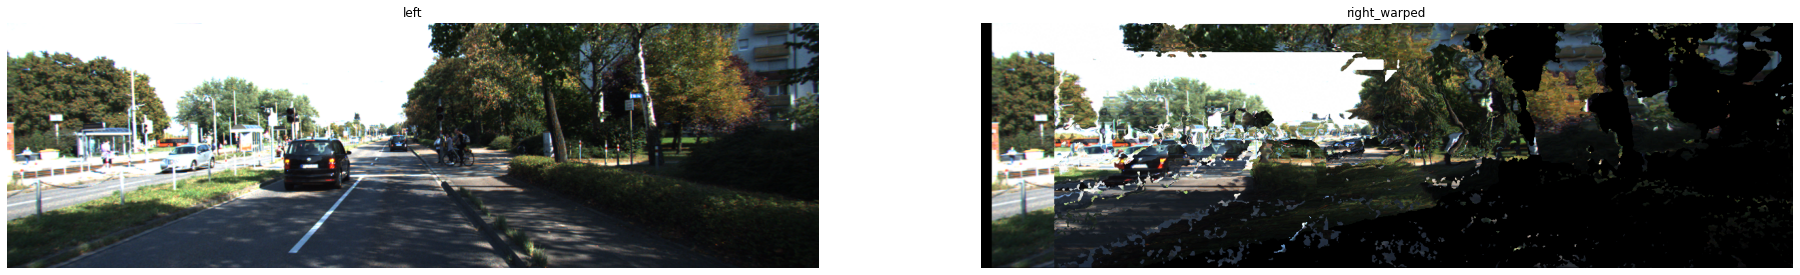

In [9]:
right_img_warped = right_img_warped.cpu().numpy()
right_img_warped = np.transpose(right_img_warped[0], (1, 2, 0))
right_img_warped = np.array(right_img_warped, dtype=np.uint8)
plt.figure(figsize=(32, 8))
plt.subplot(121)
plt.imshow(left_img)
plt.title('left')
plt.axis('off')
plt.subplot(122)
plt.imshow(right_img_warped)
plt.title('right_warped')
plt.axis('off')
plt.show()